In [21]:
import os,sys
import cPickle as pickle
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting
from scipy.fftpack import fft

from time import time

sys.path.insert(0,'lib/')
import config
import diagnostics
import base_model

from sklearn.metrics import average_precision_score

os.environ['CUDA_VISIBLE_DEVICES']=''

import tensorflow as tf
%matplotlib inline

In [22]:
with open(config.labels_path) as f:
    labels = pickle.load(f)

In [23]:
# windowed, exponentially distributed filters between 10Hz and 22kHz
def create_filters(d,k):
    x = np.linspace(0, 2*np.pi, d, endpoint=False)
    wsin = np.empty((1,d,1,k), dtype=np.float32)
    wcos = np.empty((1,d,1,k), dtype=np.float32)
    start_freq = 50.
    end_freq = 6000.
    num_cycles = start_freq*d/44000.
    scaling_ind = np.log(end_freq/start_freq)/k
    window_mask = 1.0#-1.0*np.cos(x)
    for ind in range(k):
        wsin[0,:,0,ind] = window_mask*np.sin(np.exp(ind*scaling_ind)*num_cycles*x)
        wcos[0,:,0,ind] = window_mask*np.cos(np.exp(ind*scaling_ind)*num_cycles*x)a
            
    return wsin,wcos

class Spectrograms(base_model.Model):
    def __init__(self, *args, **kwargs):
        super(Spectrograms, self).__init__(*args, **kwargs)

    def define_graph(self):
        super(Spectrograms, self).define_graph()
        
        # lvl1 convolutions are shared between regions
        self.k = 512              # lvl1 nodes
        self.d = 4096              # lvl1 receptive field

        # number of lvl1 features
        regions = 1 + (self.window - self.d)/self.stride
        print 'Number of V1 feature regions: {}'.format(regions)

        # preconditionable weights
        wsin,wcos = create_filters(self.d,self.k)

        with tf.variable_scope('parameters'):
            beta = tf.Variable(tf.zeros([regions*self.k,self.m]))
            betaavg = self.register_weights(beta,'beta',average=.9998)

        with tf.variable_scope('queued_model'):
            zx = tf.square(tf.nn.conv2d(self.xq,wsin,strides=[1,1,self.stride,1],padding='VALID')) \
               + tf.square(tf.nn.conv2d(self.xq,wcos,strides=[1,1,self.stride,1],padding='VALID'))
            y = tf.matmul(tf.reshape(tf.log(zx + 10e-12),[self.batch_size,regions*self.k]),beta)
            self.loss = tf.reduce_mean(tf.nn.l2_loss(y-tf.reshape(self.yq,[self.batch_size,self.m])))

        with tf.variable_scope('direct_model'):
            self.zx = tf.square(tf.nn.conv2d(self.xd,wsin,strides=[1,1,self.stride,1],padding='VALID')) \
                    + tf.square(tf.nn.conv2d(self.xd,wcos,strides=[1,1,self.stride,1],padding='VALID'))
            self.y_direct = tf.matmul(tf.reshape(tf.log(self.zx + 10e-12),[tf.shape(self.xd)[0],regions*self.k]),betaavg)
            self.loss_direct = tf.reduce_mean(tf.nn.l2_loss(self.y_direct-self.yd))

In [24]:
try: model.stop()
except NameError: pass
model = Spectrograms(labels,checkpoint_path='spectrograms_log/', outputs=1, window=16384, mmap=True,
                    normalize=True, extended_test_set=True, use_mirex=False, init=True, pitch_transforms=5, jitter=.1,
                    restrict=False, gpu_memory_growth=True)

Number of V1 feature regions: 25


In [25]:
lr = .000000001/2/2/3
mom = .95

# stop the model if it is already running
model.stop()

# we have to rebuild the graph every time because input queues can't be reopened
model.define_graph()

learning_rate = tf.placeholder(tf.float32, shape=[])
opt_op = tf.train.MomentumOptimizer(learning_rate,mom).minimize(model.loss)
with tf.control_dependencies([opt_op]):
    train_step = tf.group(*model.averages)

# start up the session, kick off the worker threads, restore checkpoint, etc.
model.start()

try:
    ptime = time()
    print model.status_header()
    while True:
        if model.iter % 1000 == 0:
            model.update_status(ptime,time(),lr)
            model.checkpoint()
            print model.status()
            ptime = time()

        model.sess.run(train_step, feed_dict={learning_rate: lr})
        model.iter += 1

except KeyboardInterrupt:
    model.checkpoint()
    print 'Graceful Exit'

Number of V1 feature regions: 25
avp_test	avp_train	mse_test	mse_train	time	utime
0.017702        0.022713        1.132950        1.453633        30      30      
0.222853        0.268583        1.101532        1.414688        269     17      
0.355307        0.390037        1.065047        1.369210        202     17      
0.439227        0.450420        1.028410        1.322627        467     171     
Graceful Exit


0.4392265851699775
1.02841027058505


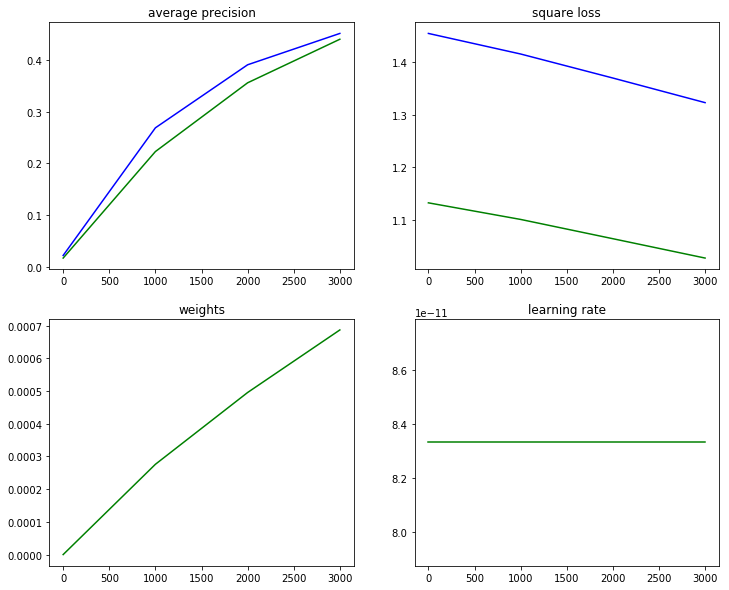

In [26]:
burnin=0
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2)
fig.set_figwidth(12)
fig.set_figheight(10)
ax1.set_title('average precision')
ax1.plot(model.stats['iter'][2][burnin:],model.stats['avp_test'][2][burnin:],color='g')
ax1.plot(model.stats['iter'][2][burnin:],model.stats['avp_train'][2][burnin:],color='b')
ax2.set_title('square loss')
ax2.plot(model.stats['iter'][2][burnin:],model.stats['mse_test'][2][burnin:],color='g')
ax2.plot(model.stats['iter'][2][burnin:],model.stats['mse_train'][2][burnin:],color='b')
ax3.set_title('weights')
ax3.plot(model.stats['iter'][2][burnin:],model.stats['nbeta'][2][burnin:],color='g')
ax4.set_title('learning rate')
ax4.plot(model.stats['iter'][2][burnin:],model.stats['lr'][2][burnin:],color='g')

print max(model.stats['avp_test'][2])
print min(model.stats['mse_test'][2])

# Mirex Stats

In [9]:
mse_test, Yhat, Y, mse_breakdown, avp_breakdown = model.sample_records(config.test_ids, 7500, fixed_stride=512)
avp_test = average_precision_score(Y.flatten(),Yhat.flatten())
print avp_test

0.4475331265699728


In [7]:
Accavg = Etotavg = 0
for i in range(3):
    _,_,_,Acc,Etot = diagnostics.mirex_statistics(model,i,threshold=.4)
    Accavg += Acc
    Etotavg += Etot

print Accavg/3.,Etotavg/3.

AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
70.97	73.28	63.45	0.52	0.50	0.10	0.27	0.13
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
35.45	50.38	30.01	0.23	0.87	0.13	0.57	0.17
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
73.83	77.20	51.47	0.45	0.57	0.06	0.42	0.09
0.397895741753 0.646460766455


# Extended test set stats

In [27]:
mse_test, Yhat, Y, mse_breakdown, avp_breakdown = model.sample_records(config.test_ids_ext, 7500, fixed_stride=512)
avp_test = average_precision_score(Y.flatten(),Yhat.flatten())
print avp_test

0.4559413957006892


In [28]:
Accavg = Etotavg = 0
for i in range(10):
    _,_,_,Acc,Etot = diagnostics.mirex_statistics(model,i,threshold=.4)
    Accavg += Acc
    Etotavg += Etot

print Accavg/10.,Etotavg/10.

c:\Users\intel\Anaconda3\envs\py27\lib\site-packages\mir_eval\multipitch.py:275: UserWarning: Estimate frequencies are all empty.
  warnings.warn("Estimate frequencies are all empty.")


AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
46.82	0.00	0.00	0.00	1.00	0.00	1.00	0.00
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
26.81	0.00	0.00	0.00	1.00	0.00	1.00	0.00
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
57.64	0.00	0.00	0.00	1.00	0.00	1.00	0.00
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
36.35	0.00	0.00	0.00	1.00	0.00	1.00	0.00
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
43.77	0.00	0.00	0.00	1.00	0.00	1.00	0.00
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
42.16	0.00	0.00	0.00	1.00	0.00	1.00	0.00
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
44.99	0.00	0.00	0.00	1.00	0.00	1.00	0.00
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
46.91	0.00	0.00	0.00	1.00	0.00	1.00	0.00
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
50.37	0.00	0.00	0.00	1.00	0.00	1.00	0.00
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
46.29	0.00	0.00	0.00	1.00	0.00	1.00	0.00
0.0 1.0
